In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv


In [80]:
df = pd.read_csv("../input/../input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv")
df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


* Target - ***churn*** (True/False)

* Препроцессинг данных с https://www.kaggle.com/shivatinker/lab-2

In [81]:
df = df.drop(['state', 'phone number'], axis='columns')
df['area code'] = df['area code'].map({408: 0, 415: 1, 510: 2})
df['voice mail plan'] = df['voice mail plan'].map( {"no": 0,"yes": 1} )
df['international plan'] = df['international plan'].map( {"no": 0,"yes": 1} )
df['churn'] = df['churn'].map( {False: 0, True: 1 })
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


* Подготовим тестовые данные (код из 2 лабы)

In [82]:
scaler = StandardScaler()
Xs = df.drop('churn', axis='columns')
X = scaler.fit_transform(df.drop('churn', axis='columns'))
Y = df['churn']
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.25, random_state=42)

Метрика F1 обьяснена в прошлой лабе

In [83]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
res = tree.predict(X_valid)
print(f1_score(y_valid, res))

0.7557603686635944


Подберем max_depth

{'max_depth': 6}
0.7577630468199923


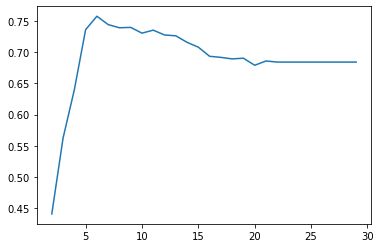

In [84]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

params = {'max_depth': np.arange(2, 30)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['max_depth'], grid.cv_results_['mean_test_score'])

In [85]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)

Подберем min_samples_split

{'min_samples_split': 9}
0.7628736014942911


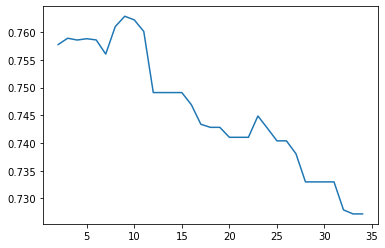

In [86]:
params = {'min_samples_split': np.arange(2, 35)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['min_samples_split'], grid.cv_results_['mean_test_score'])

In [87]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=9, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=9, random_state=42)

{'min_samples_leaf': 12}
0.75825477953202


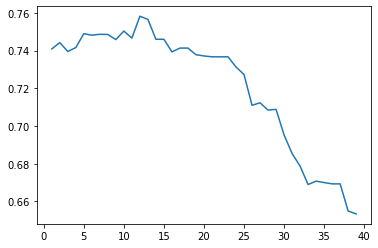

In [88]:
params = {'min_samples_leaf': np.arange(1, 40)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['min_samples_leaf'], grid.cv_results_['mean_test_score'])

In [89]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=9, min_samples_leaf= 12, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=12, min_samples_split=9,
                       random_state=42)

{'max_features': 17}
0.7580541023162994


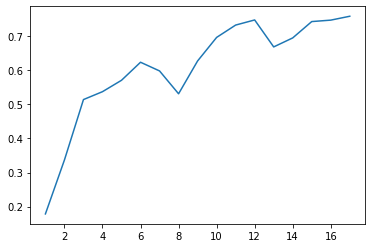

In [90]:
params = {'max_features': np.arange(1, 18)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['max_features'], grid.cv_results_['mean_test_score'])

In [91]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=9, min_samples_leaf=12, max_features=17, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=17, min_samples_leaf=12,
                       min_samples_split=9, random_state=42)

In [92]:
export_graphviz(tree, out_file='tree.dot', feature_names=Xs.columns)

In [93]:
features = list(enumerate(Xs.columns))

inds = np.argsort(tree.feature_importances_)[::-1]

for i in range(num_to_plot):
    print(features[inds[i]], tree.feature_importances_[inds[i]])

(7, 'total day charge') 0.20416138957402968
(17, 'customer service calls') 0.1538188690666516
(15, 'total intl calls') 0.12356276037086658
(2, 'international plan') 0.10834663405628774
(5, 'total day minutes') 0.10284871878253567
(16, 'total intl charge') 0.08853406506323773
(8, 'total eve minutes') 0.07337652164827653
(4, 'number vmail messages') 0.06464745348737191
(10, 'total eve charge') 0.06451476217305137
(13, 'total night charge') 0.0078098854085267904


Выводы очевидны

Делаем абсолютно такой же скучный код для фореста =(

In [94]:
tree = RandomForestClassifier(random_state=42)
tree.fit(X_train, y_train)
res = tree.predict(X_valid)
print(f1_score(y_valid, res))

0.7926267281105991


{'n_estimators': 200}
0.8232405321595925


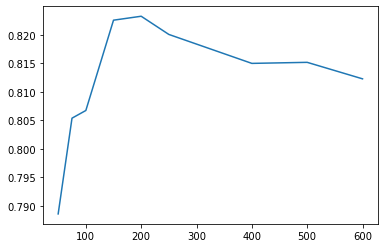

In [96]:
params = {"n_estimators":[50, 75, 100, 150, 200, 250, 400, 500, 600]}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['n_estimators'], grid.cv_results_['mean_test_score'])

{'max_depth': 9}
0.7965314833190191


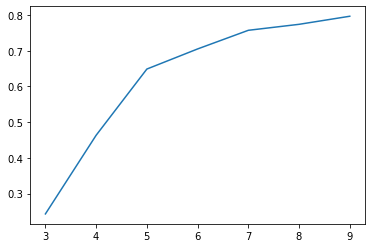

In [98]:
tree = RandomForestClassifier(random_state=42, n_estimators=200)
params = {'max_depth': np.arange(3, 10)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['max_depth'], grid.cv_results_['mean_test_score'])

{'min_samples_split': 5}
0.8022231273326768


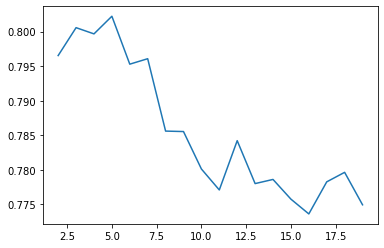

In [99]:
tree = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=9)
params = {'min_samples_split': np.arange(2, 20)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['min_samples_split'], grid.cv_results_['mean_test_score'])

{'min_samples_leaf': 4}
0.7801706628983981


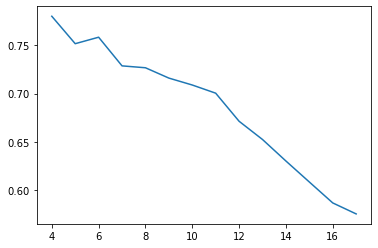

In [101]:
tree = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=9, min_samples_split=5)
params = {'min_samples_leaf': np.arange(4, 18)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['min_samples_leaf'], grid.cv_results_['mean_test_score'])

{'max_features': 6}
0.8073943662460362


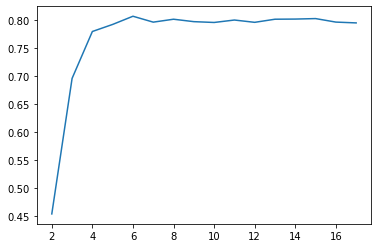

In [102]:
tree = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=9, min_samples_split=5, min_samples_leaf=4)
params = {'max_features': np.arange(2, 18)}
grid = GridSearchCV(tree, params, cv=kfold, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
sns.lineplot(params['max_features'], grid.cv_results_['mean_test_score'])

In [105]:
tree = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=9, min_samples_split=5, min_samples_leaf=4, max_features=6)
tree.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=6, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [106]:
features = list(enumerate(Xs.columns))

inds = np.argsort(tree.feature_importances_)[::-1]

for i in range(num_to_plot):
    print(features[inds[i]], tree.feature_importances_[inds[i]])

(5, 'total day minutes') 0.156654079426111
(7, 'total day charge') 0.1503546761769785
(17, 'customer service calls') 0.14960924091809608
(2, 'international plan') 0.10662067655248932
(10, 'total eve charge') 0.06891949934784479
(8, 'total eve minutes') 0.0671592365735656
(15, 'total intl calls') 0.05943473280849133
(16, 'total intl charge') 0.040100924449438496
(14, 'total intl minutes') 0.0394127423743718
(4, 'number vmail messages') 0.034246820117893845


Для сравнения у дерева:

In [109]:
"""
(7, 'total day charge') 0.20416138957402968
(17, 'customer service calls') 0.1538188690666516
(15, 'total intl calls') 0.12356276037086658
(2, 'international plan') 0.10834663405628774
(5, 'total day minutes') 0.10284871878253567
(16, 'total intl charge') 0.08853406506323773
(8, 'total eve minutes') 0.07337652164827653
(4, 'number vmail messages') 0.06464745348737191
(10, 'total eve charge') 0.06451476217305137
(13, 'total night charge') 0.0078098854085267904
"""

"\n(7, 'total day charge') 0.20416138957402968\n(17, 'customer service calls') 0.1538188690666516\n(15, 'total intl calls') 0.12356276037086658\n(2, 'international plan') 0.10834663405628774\n(5, 'total day minutes') 0.10284871878253567\n(16, 'total intl charge') 0.08853406506323773\n(8, 'total eve minutes') 0.07337652164827653\n(4, 'number vmail messages') 0.06464745348737191\n(10, 'total eve charge') 0.06451476217305137\n(13, 'total night charge') 0.0078098854085267904\n"

Выводы все так же очевидны, total day charge и total day minutes, а так же customer service calls являются топовыми фичами, по которым можно установить лояльность клиента

По методам:
* KNN - Не круто (47%)
* Дерево - Круто (76%)
* Лес деревьев - Еще круче (81%)

(Я бы нарисовал гистограмму, но синтаксис гистограмм в python заставляет меня задуматься о том, чтобы перестать заниматься программированием и начать выращивать цветы)